# HiddenLayer Train Demo - Keras

In [1]:
import os
import time
import random
import numpy as np
import hiddenlayer as hl

## Basic Use Case

To track your training, you need to use two Classes: History to store the metrics, and Canvas to draw them.
This example simulates a training loop.

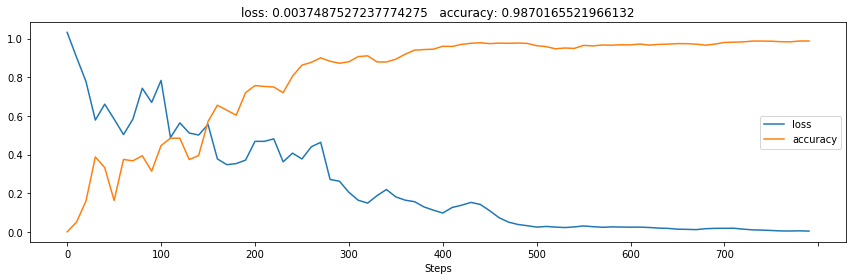

In [2]:
# A History object to store metrics
history1 = hl.History()

# A Canvas object to draw the metrics
canvas1 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        # Store metrics in the history object
        history1.log(step, loss=loss, accuracy=accuracy)

        # Plot the two metrics in one graph
        canvas1.draw_plot([history1["loss"], history1["accuracy"]])

        time.sleep(0.1)

## Comparing Experiments

Often you'd want to compare how experiments compare to each other. 

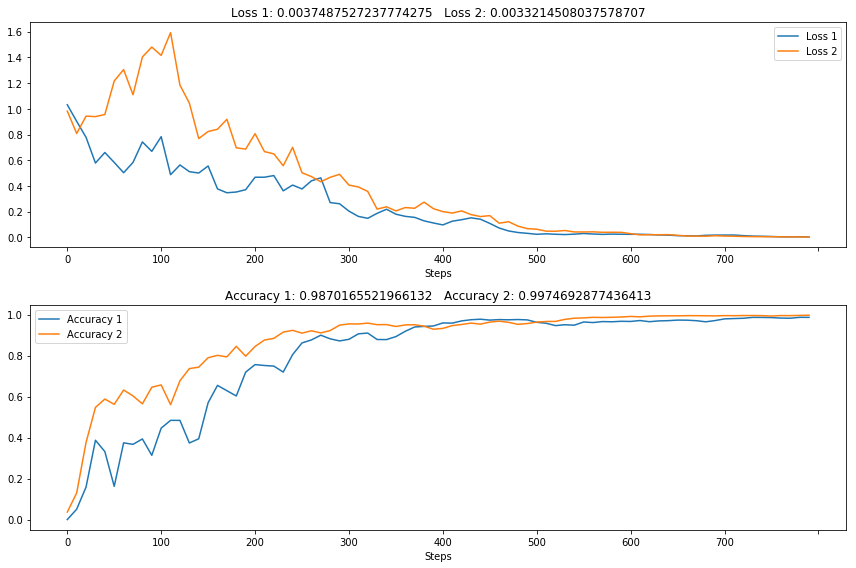

In [3]:
# New history and canvas objects
history2 = hl.History()
canvas2 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        history2.log(step, loss=loss, accuracy=accuracy)

        # Draw two plots
        # Encluse them in a "with" context to ensure they render together
        with canvas2:
            canvas2.draw_plot([history1["loss"], history2["loss"]],
                              labels=["Loss 1", "Loss 2"])
            canvas2.draw_plot([history1["accuracy"], history2["accuracy"]],
                              labels=["Accuracy 1", "Accuracy 2"])
        time.sleep(0.1)

## Saving and Loading Histories

The History object store the metrics in RAM, which is often good enough for simple 
expriments. To keep the history, you can save/load them with.

In [4]:
# Save experiments 1 and 2
history1.save("experiment1.pkl")
history2.save("experiment2.pkl")

In [5]:
# Load them again. To verify it's working, load them into new objects.
h1 = hl.History()
h2 = hl.History()
h1.load("experiment1.pkl")
h2.load("experiment2.pkl")

Verify the data is loaded

In [6]:
# Show a summary of the experiment
h1.summary()

Last Step: 790
Training Time: 0:00:31.288706


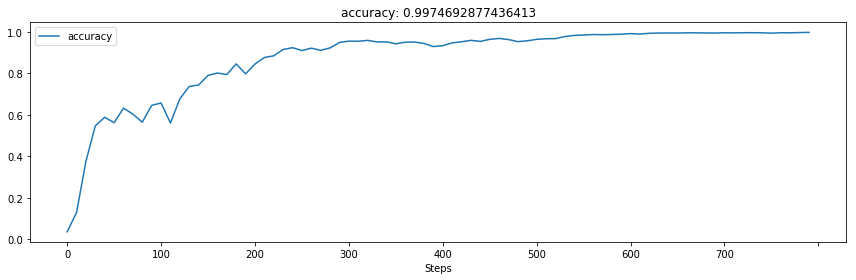

In [7]:
# Draw a plot of experiment 2
hl.Canvas().draw_plot(h2["accuracy"])

## Custom Visualizations

Adding new custom visualizations is pretty easy. Derive a new class from `Canvas` and add your new method to it. You can use any of the drawing functions provided by `matplotlib`.

Here is an example to display the accuracy metric as a pie chart.

In [8]:
class MyCanvas(hl.Canvas):
    """Extending Canvas to add a pie chart method."""
    
    def draw_pie(self, metric):
        # Method name must start with 'draw_' for the Canvas to automatically manage it
        
        # Use the provided matplotlib Axes in self.ax
        self.ax.axis('equal')  # set square aspect ratio

        # Get latest value of the metric
        value = np.clip(metric.data[-1], 0, 1)
        
        # Draw pie chart
        self.ax.pie([value, 1-value], labels=["Accuracy", ""])

In addition to the pie chart, let's use image visualizations (which is built-in).

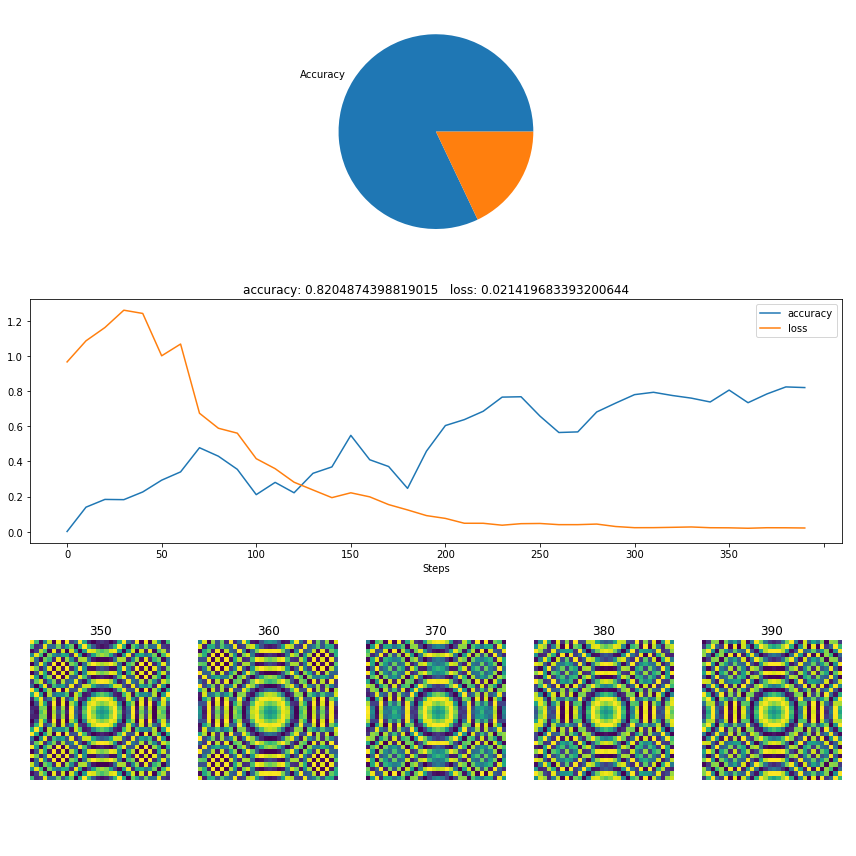

In [9]:
history3 = hl.History()
canvas3 = MyCanvas()  # My custom Canvas

# Simulate a training loop
loss = 1
accuracy = 0
for step in range(400):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    if step % 10 == 0:
        # Log loss and accuracy
        history3.log(step, loss=loss, accuracy=accuracy)

        # Log a fake image metric (e.g. image generated by a GAN)
        image = np.sin(np.sum(((np.indices([32, 32]) - 16) * 0.5 * accuracy) ** 2, 0))
        history3.log(step, image=image)
        
        # Display
        with canvas3:
            canvas3.draw_pie(history3["accuracy"])
            canvas3.draw_plot([history3["accuracy"], history3["loss"]])
            canvas3.draw_image(history3["image"])

        time.sleep(0.1)

## Running without a GUI

If the training loop is running on a server without a GUI, then use the `History` `progress()` method to print a text status.

In [10]:
# Print the metrics of the last step.
history1.progress()

Step 790: loss: 0.0037487527237774275  accuracy: 0.9870165521966132  


You can also periodically saving a snapshot of the graphs to disk to view later. See `demos/history_demo.py` for an example.

First, set matplotlib backend to Agg.
```Python
# Set matplotlib backend to Agg. MUST be done BEFORE importing hiddenlayer
import matplotlib
matplotlib.use("Agg")
```

Then, in the training loop:
```
    # Print a text progress status in the loop
    history.progress()

    # Occasionally, save a snapshot of the graphs.
    canvas.draw_plot([h["loss"], h["accuracy"]])
    canvas.save("training_graph.png")
```

## Real Training Example

Below, we train an MNIST classifier using transfer learning with:
- a pre-trained VGG16 convnet for feature extraction,
- our own 10-output sotfmax layer with cross-entropy loss (log loss) as our classifier.

We use:
- `Keras` for model training
- `sklearn` to generate a confusion matrix on the validation split
- `hiddenlayer` to validate our "before/after" convnet and check our progress (visualizing the confusion matrix as we go)

This model only takes **~3 minutes to train** to reach 97% prediction accuracy on the validation split.

In [11]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import itertools
from matplotlib import pyplot as plt

## Hyperparams and constants

In [12]:
# Minimum size of input images Keras' VGG16 will accept
input_shape = (48, 48, 3)

## Prepare the train/val dataset splits

In [13]:
# Load the data using the default train/validation split
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Extract image size
_, x_height, x_width = x_train.shape

# Extract number of classes
y_classes = len(np.unique(y_train))

In [14]:
# Sanity check
hl.write("x_train", x_train)
hl.write("x_val", x_val)
hl.write("y_train", y_train)
hl.write("y_val", y_val)
print(f"Sample size: {x_height}x{x_width}")
print(f"Number of classes: {y_classes}")

x_train	Tensor  uint8 (60000, 28, 28)  min: 0.000  max: 255.000
x_val	Tensor  uint8 (10000, 28, 28)  min: 0.000  max: 255.000
y_train	Tensor  uint8 (60000,)  min: 0.000  max: 9.000
y_val	Tensor  uint8 (10000,)  min: 0.000  max: 9.000
Sample size: 28x28
Number of classes: 10


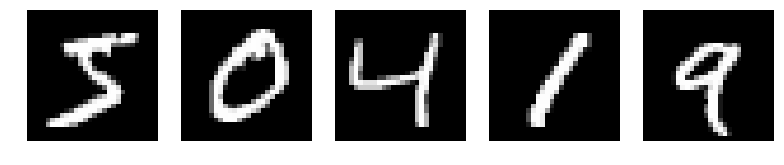

In [15]:
# Visual check
hl.show_images(x_train[:5])

## Adapt the train/val splits to the convnet input/label format requirements

In [16]:
# The VGG16 backbone was trained on RGB data in the [0.,1.] range
# -> convert data to float and perform min-max normalization
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255

# The VGG16 backbone was trained on color RGB data (imagenet)
# -> resize the samples from (#, 28, 28) to (#, input_shape[0], input_shape[1])
if input_shape[0:2] != (x_height, x_width):
    x_train = [cv2.resize(x, input_shape[0:2]) for x in x_train]
    x_val = [cv2.resize(x, input_shape[0:2]) for x in x_val]

# -> reshape the samples from (#, H, W) to (#, H, W, 3)
#    by copying the "gray" MNIST images identically across the 3 RGB channels
x_train = np.stack((x_train, x_train, x_train), axis=-1)
x_val = np.stack((x_val, x_val, x_val), axis=-1)

In [17]:
# One-hot encode labels for use by softmax with multiclass cross-entropy loss
y_train = to_categorical(y_train, y_classes)
y_val = to_categorical(y_val, y_classes)

In [18]:
# Sanity check
hl.write("x_train", x_train)
hl.write("x_val", x_val)
hl.write("y_train", y_train)
hl.write("y_val", y_val)

x_train	Tensor  float32 (60000, 48, 48, 3)  min: 0.000  max: 1.000
x_val	Tensor  float32 (10000, 48, 48, 3)  min: 0.000  max: 1.000
y_train	Tensor  float32 (60000, 10)  min: 0.000  max: 1.000
y_val	Tensor  float32 (10000, 10)  min: 0.000  max: 1.000


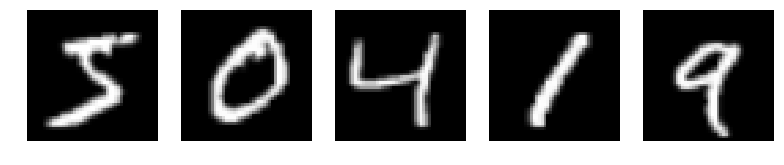

In [19]:
# Visual check
hl.show_images(x_train[:5])

## Put the model (convnet base + classifier) together

In [20]:
# Set the learning phase to training
K.set_learning_phase(1)

In [21]:
# Build the VGG16 model as a feature extractor
convnet = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

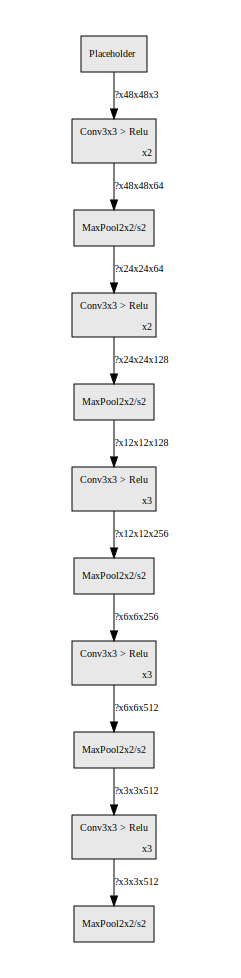

In [22]:
# Visual check of the "before" model architecture using HiddenLayer
hl.build_graph(K.get_session().graph)

In [23]:
# Build our own classifier on top of the VGG16 feature extractor using
# two fully-connected layers with dropout and a final softmax layer
classifier = Flatten(input_shape=convnet.output_shape[1:])(convnet.output)
classifier = Dense(512, activation='relu')(classifier) # fc1
classifier = Dropout(0.5)(classifier)
classifier = Dense(512, activation='relu')(classifier) # fc2
classifier = Dropout(0.5)(classifier)
classifier = Dense(10, activation='softmax')(classifier) # softmax classifier for classes 0..9

In [24]:
# Finally, put the model together
model = Model(inputs=convnet.input, outputs=classifier)

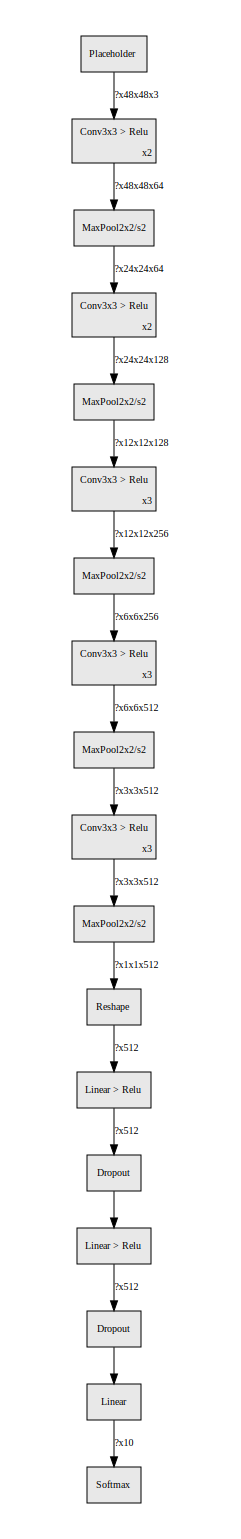

In [25]:
# Visual check of the "after" model architecture using HiddenLayer
hl.build_graph(K.get_session().graph)

## Subclass Canvas and add draw_confusion_matrix()

In [26]:
class ConfusionMatrixCanvas(hl.Canvas):
    """Extending HiddenLayer's Canvas to plot a confusion matrix."""

    def __init__(self, classes):
        super().__init__()
        self.classes = range(0, classes)
    
    def draw_confusion_matrix(self, metric):
        """This function plots the confusion matrix.
        Ref:
            https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        # Get confusion matrix of the last step
        cm = metric.data[-1]

        # Build the plot
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        

## Create a Keras callback to compute and visualize a confusion matrix

In [27]:
class ConfusionMatrixCallback(Callback):
    """Extending Keras' Callback to compute a confusion matrix."""
    
    def __init__(self, x_val, y_val, y_classes):
        # Keep a reference to the validation data
        self.x_val = x_val
        self.y_val = [np.argmax(y) for y in y_val]
        
        # Use a HiddenLayer History object to store metrics
        self.history = hl.History()

        # Use our custom HiddenLayer Canvas object to draw the metrics
        self.canvas = ConfusionMatrixCanvas(y_classes)        
        
    def on_train_begin(self, logs={}):
        self.epoch = 0
              
    def on_epoch_end(self, batch, logs={}):
        # Generate predictions for validation data
        y_val_hat = self.model.predict(self.x_val)
        y_val_hat = [np.argmax(y) for y in y_val_hat]
              
        # Compute the accuracy and generate a confusion matrix using the validation data
        val_acc = accuracy_score(self.y_val, y_val_hat)
        cm = confusion_matrix(self.y_val, y_val_hat)
              
        # Store the metrics in the history object
        self.history.log(self.epoch, acc=logs.get('acc'), val_acc=val_acc, cm=cm)
        
        # Plot the metrics
        with self.canvas:
            self.canvas.draw_confusion_matrix(self.history["cm"])
            self.canvas.draw_plot([self.history["acc"], self.history["val_acc"]])
              
        # Onto the next epoch...
        self.epoch += 1

callbacks = [ConfusionMatrixCallback(x_val, y_val, y_classes)]

## Compile the model so we'll only train the classifier head

In [28]:
# Since we only want to use the convnet as a feature extractor, 
# freeze the convnet layers and only train the classifier head
for layer in convnet.layers:
    layer.trainable = False

In [29]:
# Compile the model using the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['acc'])

## Train the model

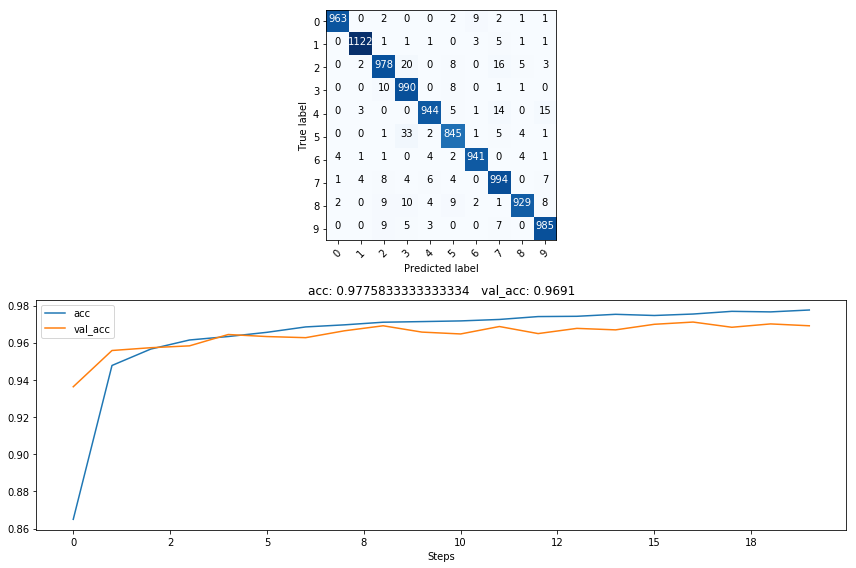

In [30]:
# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, callbacks=callbacks);